<a href="https://colab.research.google.com/github/aakankshch/CNN/blob/main/Potato_Disease_Classification_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Importing the libraries
import numpy as np
import matplotlib.pyplot as plt


import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator

In [3]:
path='/content/drive/MyDrive/data/PDC Split Folders'

In [4]:
IMAGE_SIZE = 256
CHANNELS = 3
BATCH_SIZE=32

In [5]:
#Setting up the Image Data Generator for Data Augmentation
datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True
)

In [6]:
#Generate batches of images for training from genarator
train_generator = datagen.flow_from_directory(
        f'{path}/train',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode="sparse",
)

Found 1721 images belonging to 3 classes.


In [7]:
validation_generator = datagen.flow_from_directory(
        f'{path}/val',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="sparse"
)


test_generator = datagen.flow_from_directory(
        f'{path}/test',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="sparse"
)

Found 215 images belonging to 3 classes.
Found 216 images belonging to 3 classes.


In [8]:
#Class Names
class_names = list(train_generator.class_indices.keys())
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [9]:
#There are 3 classes
len(class_names)

3

In [10]:
#Number of Batches
len(train_generator)

54

In [11]:
#Printing the shape of second batch first image
train_generator[1][0][0].shape

(256, 256, 3)

In [12]:
for image_batch, label_batch in train_generator:
    print(image_batch.shape) #Batch Size,Image Size, No, of Channels
    break

(32, 256, 256, 3)


In [13]:
for image_batch, label_batch in train_generator:
    print(label_batch) #labels in the batch
    break

[1. 1. 1. 0. 1. 1. 0. 1. 2. 0. 0. 0. 1. 1. 0. 2. 0. 0. 0. 1. 1. 0. 2. 1.
 0. 0. 0. 0. 1. 0. 1. 0.]


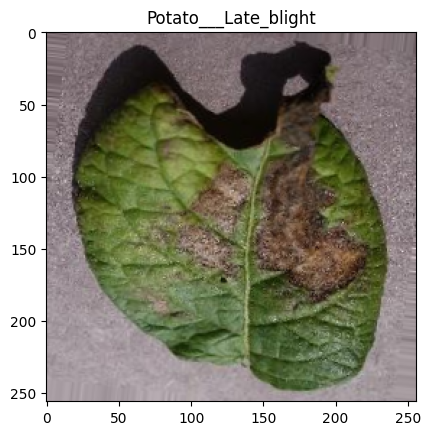

In [14]:
# Displaying the image
for image_batch,label_batch in train_generator:
    plt.imshow(image_batch[0])
    plt.title(class_names[int(label_batch[0])])
    break


In [15]:
from keras.applications.resnet50 import ResNet50

from keras.layers import Flatten,Dense
from keras.models import Model

In [16]:
# Building Resnet50 Model and not including the fully connected layer at the top of the network
resnet = ResNet50(input_shape= (IMAGE_SIZE,IMAGE_SIZE,3), weights='imagenet', include_top=False)

# Not training existing weights
for layer in resnet.layers:
    layer.trainable = False

#Flattening the Resnet output
x=Flatten()(resnet.output)

#Adding our final layers to the Resnetoutput
final_layers = Dense(len(class_names), activation='softmax')(x)

# Creating a model object using Resnet
resnet_model = Model(inputs=resnet.input, outputs=final_layers)

94765736/94765736 [==============================] - 1s 0us/step


In [17]:
# Summary of the model
resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [18]:
resnet_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
#Fitting the model with train images
resnet_model_fit = resnet_model.fit(train_generator,
                      steps_per_epoch=len(train_generator),
                      batch_size=BATCH_SIZE,
                      validation_data=validation_generator,
                      validation_steps=len(validation_generator),
                      verbose=1,
                      epochs=20,
)

Epoch 1/20
54/54 [==============================] - 654s 12s/step - loss: 2.1422 - accuracy: 0.6496 - val_loss: 1.2736 - val_accuracy: 0.6558
Epoch 2/20
54/54 [==============================] - 623s 12s/step - loss: 1.1528 - accuracy: 0.7240 - val_loss: 0.3408 - val_accuracy: 0.8698
Epoch 3/20
54/54 [==============================] - 630s 12s/step - loss: 0.8744 - accuracy: 0.7623 - val_loss: 0.6555 - val_accuracy: 0.8326
Epoch 4/20
54/54 [==============================] - 617s 11s/step - loss: 1.0149 - accuracy: 0.7827 - val_loss: 1.2751 - val_accuracy: 0.6837
Epoch 5/20
54/54 [==============================] - 625s 12s/step - loss: 0.8449 - accuracy: 0.7751 - val_loss: 0.4015 - val_accuracy: 0.8651
Epoch 6/20
54/54 [==============================] - 620s 11s/step - loss: 0.5932 - accuracy: 0.8321 - val_loss: 0.9465 - val_accuracy: 0.7628
Epoch 7/20
54/54 [==============================] - 621s 11s/step - loss: 0.5667 - accuracy: 0.8315 - val_loss: 0.3761 - val_accuracy: 0.8651
Epoch 

In [22]:
#Evaluate the model
scores=resnet_model.evaluate(test_generator)

7/7 [==============================] - 68s 9s/step - loss: 0.6168 - accuracy: 0.8102


In [23]:
scores #loss,accuracy values

[0.6168412566184998, 0.8101851940155029]

In [24]:
resnet_model_fit.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [25]:
#Accuracy and Loss Curves
acc = resnet_model_fit.history['accuracy']
val_acc = resnet_model_fit.history['val_accuracy']

loss = resnet_model_fit.history['loss']
val_loss = resnet_model_fit.history['val_loss']

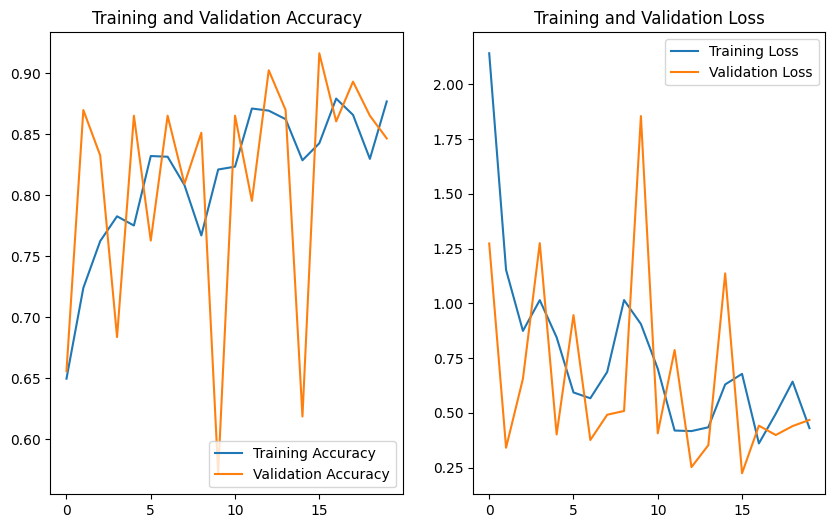

In [29]:
EPOCHS=20
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
Actual label: Potato___Early_blight
1/1 [==============================] - 11s 11s/step
Predicted label: Potato___Early_blight


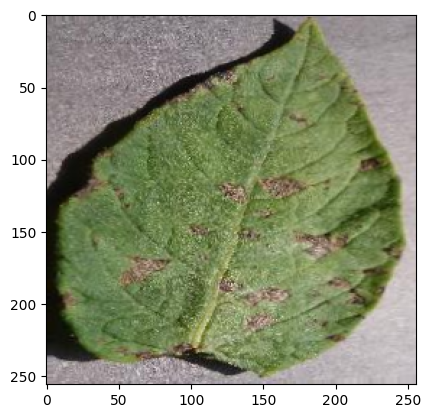

In [36]:
#Predicting 1 image
for images_batch, labels_batch in test_generator: #Taking the first batch of test dataset

    first_image = images_batch[0] #frist image of the batch
    first_label = int(labels_batch[0])

    print("First image to predict")
    plt.imshow(first_image)
    print("Actual label:",class_names[first_label])

    batch_prediction = resnet_model.predict(images_batch)
    print("Predicted label:",class_names[np.argmax(batch_prediction[0])])
    break

In [37]:
#Saving the model
resnet_model.save('/content/drive/MyDrive/data/potatoes_resnet.keras')